# ДЗ 5. LSTM

Приложен ноутбук, в котором реализованы функции для генерации из большого датасета в меньшую его копию.  
Вам нужно сделать следующее:  

- Сгенерировать меньший датасет из 8-10 классов движения  
- Обучить уже существующую модель (предварительно проанализировав, какие параметры модели нужно изменить)  
- Изменить модель: посмотреть зависимость от количества LSTM модулей в модели  
- *Сгенерировать другой датасет с меньшим количеством “кадров” в серии и сравнить улучшилось или ухудшилось качество предсказания. Провести несколько таких итераций, дать свою оценку уменьшению и увеличению кадров, назвать оптимальное, на ваш взгляд, их количество.

In [1]:
import os
import numpy as np
import pandas as pd

import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset

from torch import optim
import time, math

import matplotlib.pyplot as plt

In [2]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
device

device(type='cpu')

## Подготовка данных

Изначальный датасет довольно избыточный, поэтому для проведения задания мы пользуемся этим ноутбуком, чтобы взять только нужную часть

Скачать весь датасет (~5 Гб) можно по этой ссылке: https://drive.google.com/file/d/1CUZnBtYwifVXS21yVg62T-vrPVayso5H/view

Файл с отсутствующими скелетами можно скачать из репозитория либо с google диска wget: https://github.com/shahroudy/NTURGB-D/blob/master/Matlab/NTU_RGBD_samples_with_missing_skeletons.txt

In [3]:
data_path = "./data/nturgb_skeletons/"
# список отсутсвующих элементов
broken_files_path = "./data/missed_action_rec.txt"

In [4]:
training_classes = [8, 10, 22, 23, 27] # классы которые будем использовать 
# для обучения, полный список представлен тут https://github.com/shahroudy/NTURGB-D

training_cameras = [1, 2, 3] 

amount_of_samples = 120
num_joint = 25
max_frame = 45  # Длина отрезка которую мы достаем из датасета

Есть функция, которая позволяет нам считать данные для каждого класса. 

In [5]:
def read_data(data_path, broken_files_path):
    labels = []
    files = []
    action_classes = {}
    counter = 0
    files_counter = {}
              
    with open(broken_files_path, 'r') as f:
        broken_files = f.read().split("\n")

    raw_files = os.listdir(data_path)
    num_frames = 0

    for filename in raw_files:
        if filename not in broken_files:
            action_class = int(filename[filename.find('A') + 1:filename.find('A') + 4])
            camera_id = int(filename[filename.find('C') + 1:filename.find('C') + 4])
            
            if action_class in training_classes and camera_id in training_cameras:
                if action_class in action_classes:
                    if files_counter[action_class] < amount_of_samples:
                        files.append([filename, action_classes[action_class]])
                        files_counter[action_class] = files_counter[action_class] + 1
                else:
                    action_classes.update({action_class : counter})
                    files_counter.update({action_class : 1})
                    counter += 1
                    files.append([filename, action_classes[action_class]])

    print("action classes: ", action_classes)
    print("action files: ", files_counter)
    
    return files, action_classes

In [6]:
# Функция фильтр для того, что бы найти только координаты x, y, z (т.к. в датасете
# хранится на порядок больше информации, нежели только координаты x,y,z)
# (Остальные данные нам и не нужны, т.к. у нас нет ик-камер)
def read_skeleton_filter(file):
    with open(file, 'r') as f:
        skeleton_sequence = {}
        skeleton_sequence['numFrame'] = int(f.readline())
        skeleton_sequence['frameInfo'] = []

        for t in range(skeleton_sequence['numFrame']):
            frame_info = {}
            frame_info['numBody'] = int(f.readline())
            frame_info['bodyInfo'] = []

            for m in range(frame_info['numBody']):
                body_info = {}
                body_info_key = [
                    'bodyID', 'clipedEdges', 'handLeftConfidence',
                    'handLeftState', 'handRightConfidence', 'handRightState',
                    'isResticted', 'leanX', 'leanY', 'trackingState'
                ]
                body_info = {
                    k: float(v)
                    for k, v in zip(body_info_key, f.readline().split())
                }
                body_info['numJoint'] = int(f.readline())
                body_info['jointInfo'] = []
                for v in range(body_info['numJoint']):
                    joint_info_key = [
                        'x', 'y', 'z', 'depthX', 'depthY', 'colorX', 'colorY',
                        'orientationW', 'orientationX', 'orientationY',
                        'orientationZ', 'trackingState'
                    ]
                    joint_info = {
                        k: float(v)
                        for k, v in zip(joint_info_key, f.readline().split())
                    }
                    body_info['jointInfo'].append(joint_info)
                frame_info['bodyInfo'].append(body_info)
            skeleton_sequence['frameInfo'].append(frame_info)

    return skeleton_sequence

def read_xyz(file, max_body=1, num_joint=25):
    seq_info = read_skeleton_filter(file)
    data = np.zeros((max_body, seq_info['numFrame'], num_joint, 3))
    for n, f in enumerate(seq_info['frameInfo']):
        for m, b in enumerate(f['bodyInfo']):
            for j, v in enumerate(b['jointInfo']):
                if m < max_body and j < num_joint:
                    data[m, n, j, :] = [v['x'], v['y'], v['z']]

    return data

**В этой функции меняем количество фреймов подаваемых на вход модели**

В задании нужно пронаблюдать зависимость качества обучения модели от количества кадров, которые мы подаем в модель. Т.е. то, cколько кадров у нас отведено на один блок.

По хорошему функцию ниже нужно прописать внутри определения датасета.

In [7]:
def create_coords_blocks(data, chunk_len=45):   
    frame_counter = 0
    new_labels = []
    new_frames = []
    blocks = []
    
    test_frames = read_xyz(data_path + data[0])[0]
    label = data[1]
    slice_len = chunk_len * int(len(test_frames)/chunk_len)


    for index in range(len(test_frames[:slice_len])):
        frame_counter += 1
        new_frames.append(test_frames[index].flatten())
        if frame_counter == chunk_len:
            frame_counter = 0
            blocks.append(np.array(new_frames))
            new_labels = new_labels + [label]
            new_frames = []
       
            
    return blocks, new_labels

In [8]:
# список файлов с лейблами на каждый файл 
working_files_with_labels, action_classes = read_data(data_path, broken_files_path)

action classes:  {8: 0, 10: 1, 22: 2, 23: 3, 27: 4}
action files:  {8: 120, 10: 120, 22: 120, 23: 120, 27: 120}


In [9]:
LABELS = {v: k for k, v in action_classes.items()}

Здесь выносится сгенерированный список лейблов с номером класса.

In [10]:
LABELS

{0: 8, 1: 10, 2: 22, 3: 23, 4: 27}

In [11]:
working_files_with_labels[:10]

[['S001C001P001R001A008.skeleton', 0],
 ['S001C001P001R001A010.skeleton', 1],
 ['S001C001P001R001A022.skeleton', 2],
 ['S001C001P001R001A023.skeleton', 3],
 ['S001C001P001R001A027.skeleton', 4],
 ['S001C001P001R002A008.skeleton', 0],
 ['S001C001P001R002A010.skeleton', 1],
 ['S001C001P001R002A022.skeleton', 2],
 ['S001C001P001R002A023.skeleton', 3],
 ['S001C001P001R002A027.skeleton', 4]]

In [12]:
len(working_files_with_labels)

600

In [13]:
data = []
labels = []
numbers = {0: 0, 1 : 0, 2 : 0, 3 : 0, 4 :0}
for file_label in working_files_with_labels:
    frames_blocks, label = create_coords_blocks(file_label, chunk_len=max_frame)
    
    if label != [] and numbers[label[0]] < amount_of_samples:
        numbers[label[0]] = numbers[label[0]] + len(label)
        data = data + frames_blocks
        labels = labels + label


data_np = np.asarray(data)
labels_np = np.asarray(labels)

data_sq = data_np.reshape(len(data_np), -1)
test_data = pd.DataFrame(data_sq)
test_labels = pd.DataFrame(labels_np)
test_data['labels'] = test_labels

In [14]:
numbers

{0: 120, 1: 120, 2: 120, 3: 120, 4: 120}

In [15]:
test_data

,0,1,2,3,4,5,6,7,8,9,...,3366,3367,3368,3369,3370,3371,3372,3373,3374,labels
0,-0.080141,0.135073,3.691227,-0.058513,0.396866,3.606265,-0.037811,0.652906,3.509790,-0.066903,...,-0.066586,-0.194186,3.880914,0.103226,-0.183070,3.717531,0.180819,-0.130425,3.724300,0
1,-0.035358,0.192430,3.681518,-0.021036,0.422171,3.606487,-0.007186,0.646429,3.520689,-0.042399,...,-0.247820,0.496547,3.406900,-0.056666,0.495373,3.269386,-0.050549,0.490788,3.258667,1
2,0.399282,-0.026338,4.099298,0.382165,0.177244,4.002089,0.359935,0.376536,3.893836,0.338453,...,0.300487,0.700893,3.694455,0.535627,0.814146,3.868758,0.530421,0.797046,3.864750,2
3,0.449151,0.001842,4.170505,0.412885,0.192257,4.103466,0.375976,0.379683,4.026225,0.401664,...,0.723439,0.436599,4.077281,0.535588,0.585105,4.202623,0.536817,0.559229,4.186821,2
4,0.424387,0.040135,4.204897,0.398431,0.244353,4.116918,0.373611,0.444495,4.016130,0.355235,...,0.183856,-0.074939,3.937576,0.369532,0.690305,3.718855,0.411135,0.633985,3.657250,3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,0.312087,-0.378863,2.409601,0.295692,-0.109126,2.398817,0.279025,0.154661,2.375042,0.315696,...,-0.041539,-0.395008,2.447000,0.033147,-0.290463,2.392946,0.066328,-0.222162,2.368111,4
596,0.055381,-0.403415,2.414510,0.088547,-0.115163,2.372648,0.119760,0.166645,2.319130,0.087869,...,-0.242477,-0.399028,2.528000,0.213002,-0.448657,2.234374,0.133678,-0.386051,2.252850,4
597,0.363812,-0.355993,2.818562,0.343356,-0.071970,2.788012,0.321898,0.206311,2.745456,0.383024,...,0.202132,-0.510219,2.547600,0.477901,-0.429105,2.738215,0.471565,-0.400574,2.726966,4
598,-0.122613,-0.347504,2.336779,-0.103212,-0.024744,2.325490,-0.083856,0.289711,2.301086,-0.109478,...,-0.303258,-0.395508,2.220500,0.067754,-0.509684,2.099763,0.061477,-0.418800,2.100650,4


**Ваш итоговый файл**

In [16]:
test_data.to_csv("./data/new_skels.csv", index=False)

## LSTM

In [17]:
# class LSTM
class LSTM(nn.Module):
    def __init__(self, input_dim,hidden_dim, output_layer, layer_num):
        super().__init__()
        self.hidden_layer = hidden_layer
        self.output_layer = output_layer
        self.lstm = torch.nn.LSTM(input_dim, hidden_layer, layer_num, batch_first=True)
        self.dr = torch.nn.Dropout2d(0.1)
        self.fc = torch.nn.Linear(hidden_layer, output_layer)
        
    def forward(self, inputs):
        lstm_out, (hn, cn) = self.lstm(inputs)
        out = self.fc(lstm_out[:,-1,:])
        return out

In [18]:
# class Skeleton_Dataset
class Skeleton_Dataset(Dataset):
    def __init__(self, file_path, transform=None):
        self.data = pd.read_csv(file_path)
        self.transform = transform
        self.labels = self.data.iloc[:,-1]

    def __len__(self):
        return len(self.data)     

    def __getitem__(self, idx):
        item = np.asarray(self.data.iloc[idx,:-1]).reshape(45,25*3)
        label = self.labels[idx]
        if self.transform != None:
            item = transform(item)

        return (item, label)

In [19]:
dataset = Skeleton_Dataset(file_path = "./data/new_skels.csv", transform=None)

In [20]:
skeleton, label = dataset[41]
label, skeleton

(0,
 array([[ 2.309268e-01,  1.717751e-01,  3.468707e+00, ...,  4.021195e-01,
          7.886114e-02,  3.567400e+00],
        [ 2.294275e-01,  1.719450e-01,  3.467602e+00, ...,  3.972856e-01,
          7.944696e-02,  3.556462e+00],
        [ 2.284752e-01,  1.717147e-01,  3.468061e+00, ...,  3.986419e-01,
          7.899660e-02,  3.544917e+00],
        ...,
        [ 8.144868e-02,  1.062899e-03,  3.780097e+00, ...,  2.479305e-01,
         -1.786295e-01,  3.657214e+00],
        [ 7.967783e-02, -5.694121e-02,  3.788587e+00, ...,  2.457043e-01,
         -1.772014e-01,  3.660200e+00],
        [ 7.463989e-02, -1.510391e-01,  3.899477e+00, ...,  2.137840e-01,
         -1.745473e-01,  3.685313e+00]]))

In [21]:
LABELS[label], skeleton.shape

(8, (45, 75))

In [22]:
train_shape = 0.7
train_len = int(train_shape * len(dataset))
train_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_len, len(dataset) - train_len])
train_loader = DataLoader(train_dataset, batch_size = 16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size = 1, shuffle=True)

In [23]:
input_layer = 25 * 3
hidden_layer = 128
output_layer = len(LABELS)
layer_num = 2
model = LSTM(
    input_layer, 
    hidden_layer, 
    output_layer, 
    layer_num)
model.to(device)

LSTM(
  (lstm): LSTM(75, 128, num_layers=2, batch_first=True)
  (dr): Dropout2d(p=0.1, inplace=False)
  (fc): Linear(in_features=128, out_features=5, bias=True)
)

In [24]:
def get_target_from_output(output):
    top_n, top_i = output.topk(1)
    category_i = top_i[0].item()
    return LABELS[category_i], category_i

def time_since(since):
    now = time.time()
    s = now - since
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)

In [25]:
# Обучаем модель
criterion = nn.CrossEntropyLoss()
learning_rate = 0.0009
momentum = 0.95

optimizer = optim.SGD(
    model.parameters(), 
    lr=learning_rate, 
    momentum=momentum
)

losses = []
start = time.time()
counter = 0

for epoch in range(500):  
    loss = 0

    for i, data in enumerate(train_loader, 0):
        inputs = data[0].to(device)
        labels = data[1].to(device)

        optimizer.zero_grad()
        output = model(inputs.float())
        loss = criterion(output, labels)
        loss.backward()        
        optimizer.step() 
        loss += loss.item()
        category = LABELS[int(labels[0])]

        if counter % 500 == 0:
            guess, guess_i = get_target_from_output(output)
            correct = '✓' if guess == category else '✗ (%s)' % category
            print('Epoch %d iteration: %d (%s) %.4f  / %s %s' % (epoch, i, time_since(start), loss, guess, correct))

        counter = counter + 1
        
    if counter % 100 == 0:
        losses.append(loss / 25)
        loss = 0

Epoch 0 iteration: 0 (0m 0s) 3.2036  / 22 ✓
Epoch 18 iteration: 14 (0m 26s) 2.2281  / 22 ✓
Epoch 37 iteration: 1 (0m 52s) 2.4839  / 8 ✗ (27)
Epoch 55 iteration: 15 (1m 17s) 1.6081  / 8 ✓
Epoch 74 iteration: 2 (1m 43s) 1.6289  / 23 ✓
Epoch 92 iteration: 16 (2m 8s) 2.4100  / 23 ✓
Epoch 111 iteration: 3 (2m 34s) 1.2048  / 8 ✓
Epoch 129 iteration: 17 (2m 59s) 0.4747  / 10 ✓
Epoch 148 iteration: 4 (3m 23s) 0.9909  / 23 ✓
Epoch 166 iteration: 18 (3m 48s) 1.6953  / 8 ✓
Epoch 185 iteration: 5 (4m 13s) 0.7398  / 23 ✗ (10)
Epoch 203 iteration: 19 (4m 39s) 0.4739  / 27 ✓
Epoch 222 iteration: 6 (5m 4s) 0.3346  / 10 ✓
Epoch 240 iteration: 20 (5m 30s) 0.9267  / 22 ✓
Epoch 259 iteration: 7 (5m 55s) 0.3232  / 27 ✓
Epoch 277 iteration: 21 (6m 20s) 0.3471  / 8 ✓
Epoch 296 iteration: 8 (6m 45s) 0.4483  / 10 ✓
Epoch 314 iteration: 22 (7m 11s) 0.7564  / 22 ✓
Epoch 333 iteration: 9 (7m 37s) 0.4154  / 23 ✓
Epoch 351 iteration: 23 (8m 2s) 0.0262  / 10 ✓
Epoch 370 iteration: 10 (8m 27s) 0.3797  / 23 ✓
Epoch 38

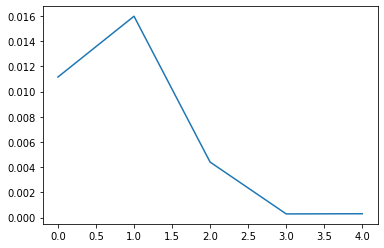

In [26]:
plt.plot(list(range(0, len(losses))), losses)
plt.show()